In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64105 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:64108" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:64130, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:64133, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:64127, threads: 2>})

In [8]:
model_data = pd.read_pickle('DFs/model_data.pkl')

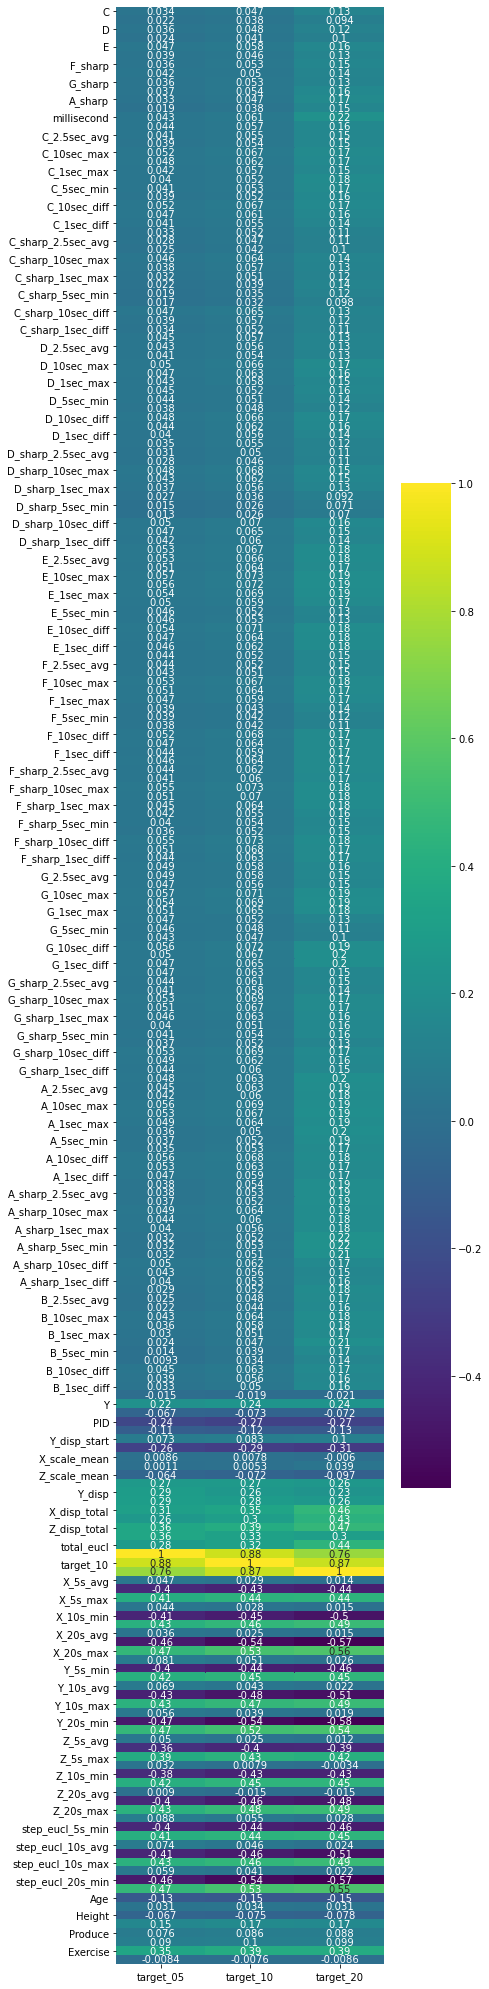

In [6]:
#Taking a look a correlations between features
corr = model_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.savefig('correlation')
plt.show()

In [7]:
model_data['segment'].unique()

array(['silence', 'class1', 'class2', 'class3', 'class4', 'hiphop',
       'salsa', 'edm'], dtype=object)

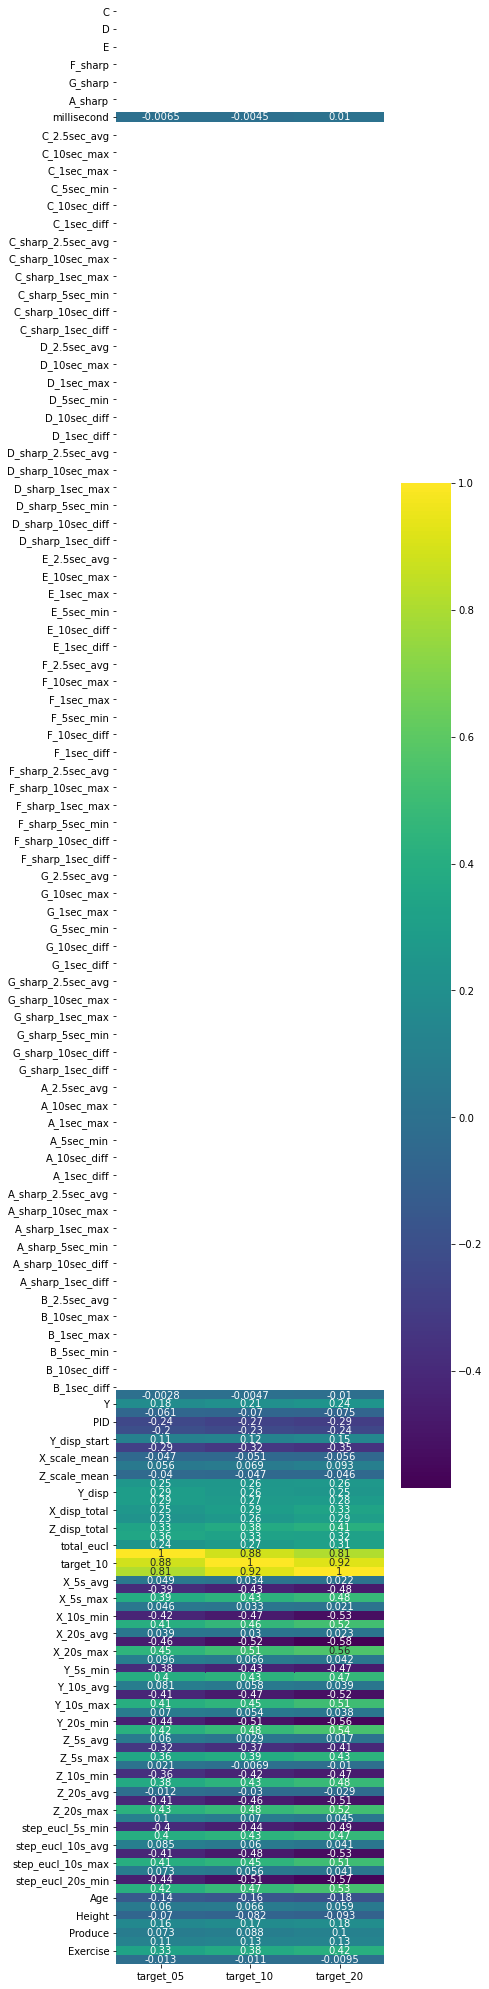

In [8]:
#Taking a look a correlations between features for silent only
silent_data = model_data.loc[model_data['segment']=='silence']
corr_sil = silent_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_sil.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

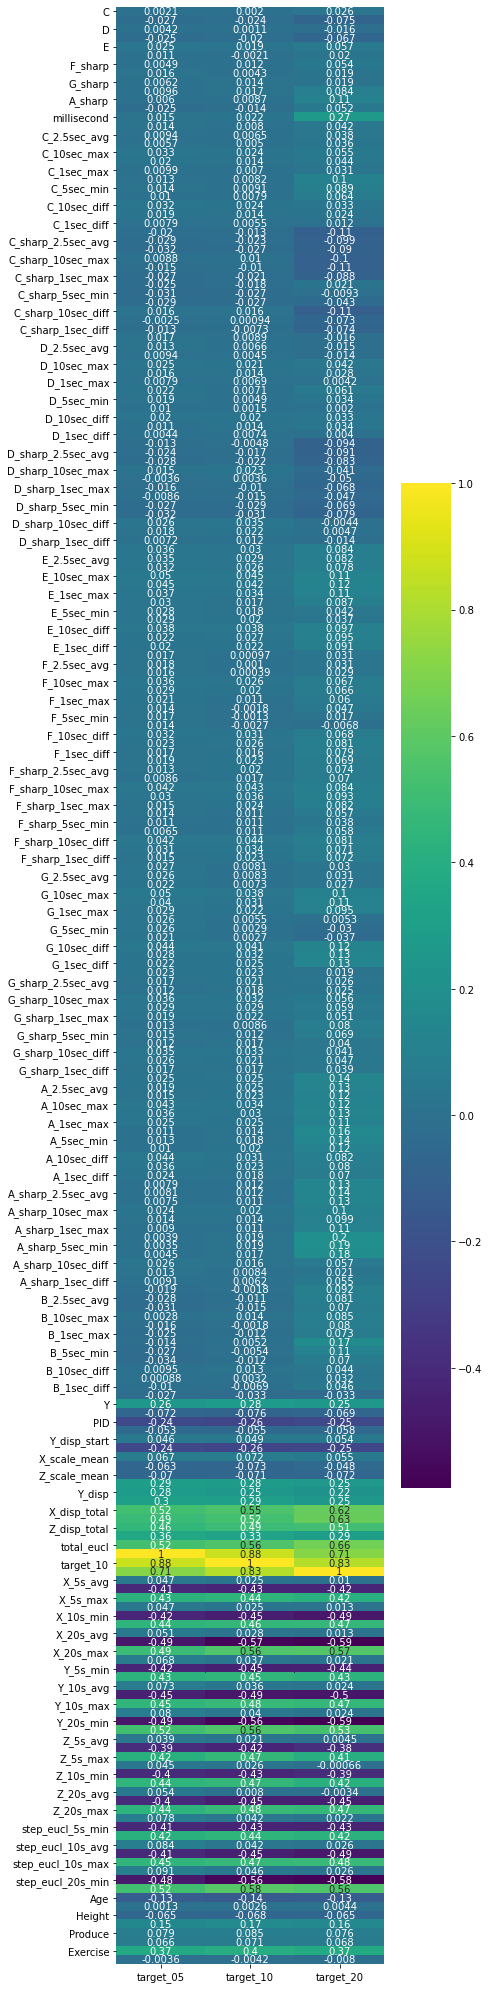

In [9]:
#Taking a look a correlations between features for non-silent only
music_data = model_data.loc[model_data['segment']!='silence']
corr_mus = music_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_mus.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

In [9]:
pca = PCA()
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
pca.fit(scaled)

PCA()

In [10]:
ex = pca.singular_values_

In [11]:
exdf = pd.DataFrame(ex.reshape(1, -1), columns =model_data.drop(columns=['segment', 'SID', 'PID']).columns )
exdf.T.rename(columns={0:'variance_explained'}).head(15)

,variance_explained
C,3916.414819
C_sharp,1483.281863
D,938.249904
D_sharp,910.992335
E,866.955581
F,759.136667
F_sharp,665.330751
G,643.128070
G_sharp,614.969447
A,597.813107


In [13]:
pca10 = PCA(n_components=10)
scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
model_pca = pca.fit_transform(scaled)

We can run an out of the box elasticNet on the PCA transformed model_data to see how it performs

In [14]:
elastic = ElasticNet()
scaler = StandardScaler()
pca10 = PCA(n_components=10)
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = scaler.fit_transform(X_train)
X_train = pca10.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = pca10.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.39134246751168855, 7.867542437805331, 0.1499519980671435)

Not very well. Let's try using the full dataset.

In [15]:
elastic = ElasticNet()
scaler = StandardScaler()
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.47600826674617935, 7.264424954031467, 0.13540267035010864)

Much better. How about if we try 50 components with the PCA to get a middle ground of computation speed and results

In [16]:
elastic = ElasticNet()
scaler = StandardScaler()
pca50 = PCA(n_components=50)
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = scaler.fit_transform(X_train)
X_train = pca50.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = pca50.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.23883796661489898, 9.028377127072005, 0.1767522246414385)

It would seem that using the whole dataset works best. Let's take a look at the predictions vs. actual when plotted

In [17]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,70.753370,69.541869
1,54.279927,53.033918
2,39.885464,53.043871
3,46.464013,53.959352
4,54.620693,59.977245
...,...,...
3457,50.872576,55.651439
3458,72.897084,63.929341
3459,53.936356,77.037681
3460,60.199130,57.740720


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

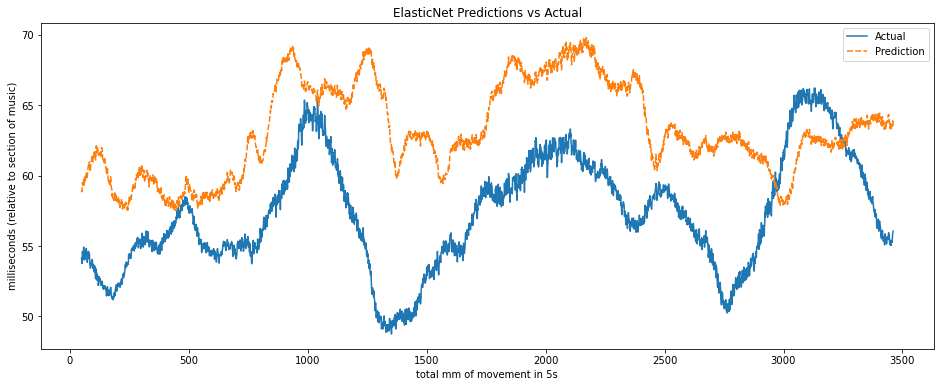

In [18]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(50).mean())
plt.title('ElasticNet Predictions vs Actual')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [19]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.055693452478900674, 9.374604357256924, 0.17090979896378292)

In [20]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,70.753370,71.507802
1,54.279927,46.911940
2,39.885464,38.725820
3,46.464013,47.508908
4,54.620693,56.345251
...,...,...
3457,50.872576,55.017896
3458,72.897084,64.648577
3459,53.936356,73.669457
3460,60.199130,42.120081


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

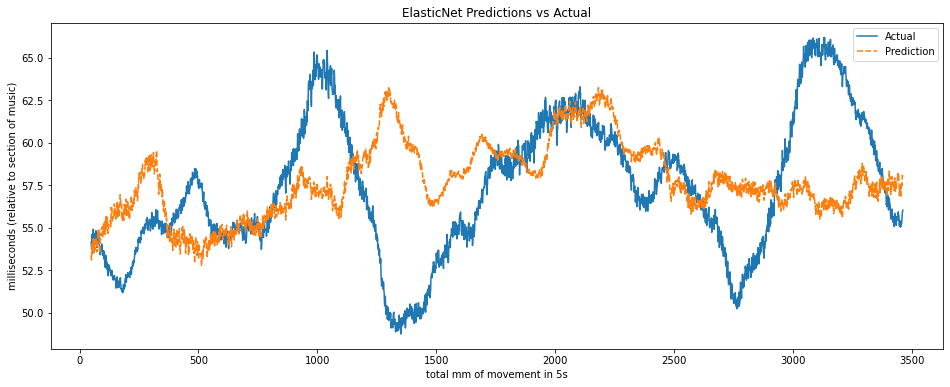

In [21]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(50).mean())
plt.title('ElasticNet Predictions vs Actual')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The RandomForest seems to be more sensitve to the changes in the motion, but on average does a worse job with prediction. We'll try it with a PCA fit of 10 components and then we'll move onto try it for target_10 and target_20.

In [22]:
rf = RandomForestRegressor()
pca10 = PCA(n_components=10)
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = pca10.fit_transform(X_train)
X_test = pca10.transform(X_test)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.10690184719798979, 8.454048333810047, 0.1512959113989032)

In [23]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,70.753370,70.386073
1,54.279927,52.161332
2,39.885464,38.316047
3,46.464013,49.439298
4,54.620693,55.870269
...,...,...
3457,50.872576,59.764504
3458,72.897084,63.412967
3459,53.936356,82.024277
3460,60.199130,66.251815


[]

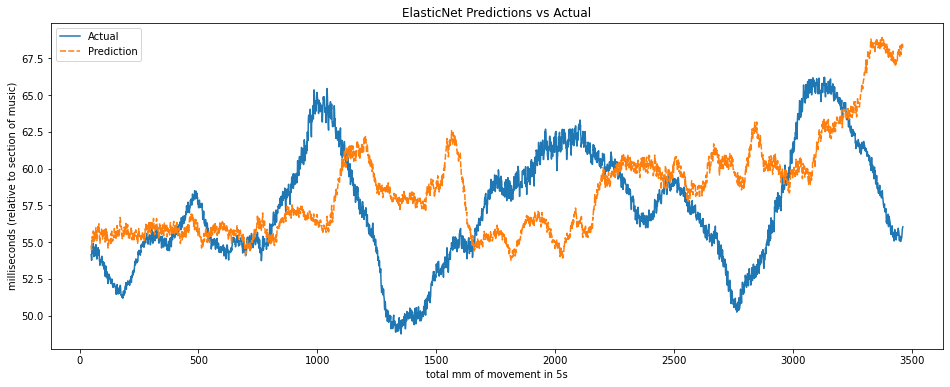

In [24]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(50).mean())
plt.title('ElasticNet Predictions vs Actual')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

## Target_10

In [25]:
elastic = ElasticNet()
scaler = StandardScaler()
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_10', 20, 25)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.6197331719364856, 11.181519082039548, 0.10045032440981343)

In [26]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,83.499876,103.618419
1,139.661177,110.248246
2,122.486802,130.886172
3,139.644109,112.878929
4,97.856936,106.369995
...,...,...
3357,136.662480,134.417754
3358,100.244984,104.058526
3359,108.260274,99.626388
3360,116.233744,109.410944


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

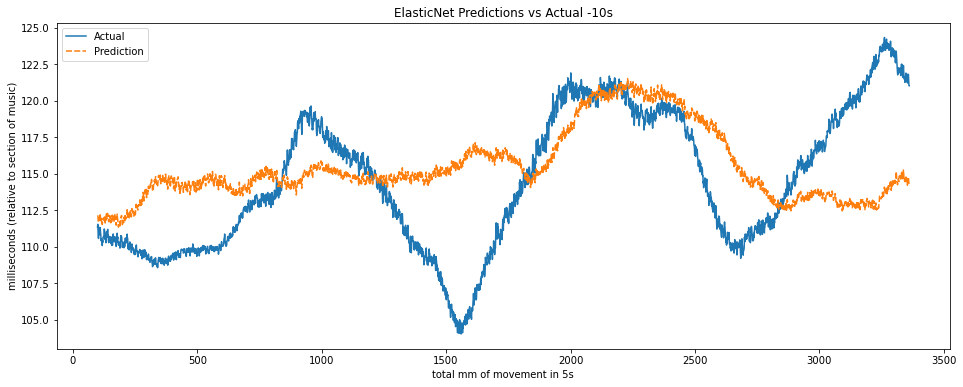

In [27]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(100).mean())
plt.title('ElasticNet Predictions vs Actual -10s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [28]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_10', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.10740562075002447, 16.929984154385775, 0.15028886138461336)

In [29]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,83.499876,82.201424
1,139.661177,139.268031
2,122.486802,125.194369
3,139.644109,138.978870
4,97.856936,98.113280
...,...,...
3357,136.662480,122.757501
3358,100.244984,94.662227
3359,108.260274,124.440906
3360,116.233744,92.091335


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

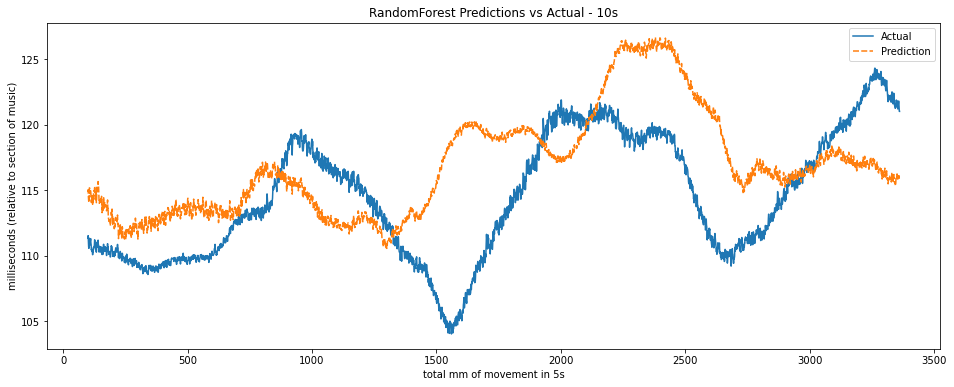

In [30]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(100).mean())
plt.title('RandomForest Predictions vs Actual - 10s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

## Target_20

In [31]:
elastic = ElasticNet()
scaler = StandardScaler()
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_20', 20, 25)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.6842038482555053, 19.326925996364114, 0.08867302483932415)

In [32]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,192.703070,207.561332
1,202.641993,220.839246
2,184.272687,187.622047
3,247.698150,224.273367
4,253.995476,266.976713
...,...,...
3157,229.428139,240.317024
3158,178.134753,212.575977
3159,218.093140,222.000298
3160,280.812631,272.616010


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

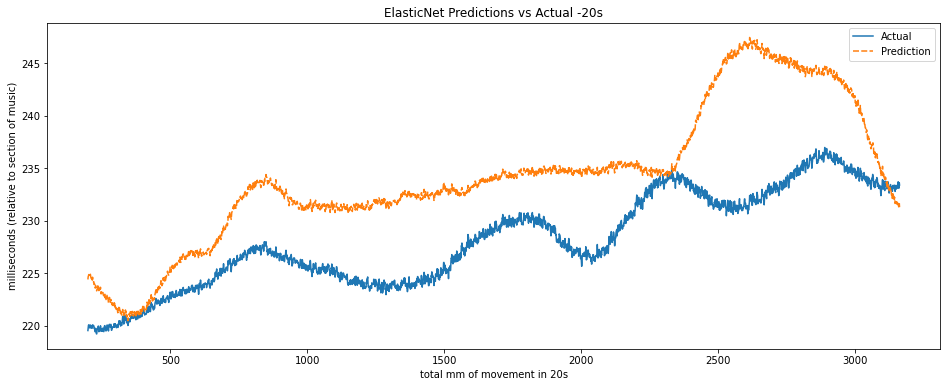

In [40]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(200).mean())
plt.title('ElasticNet Predictions vs Actual -20s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 20s')
plt.plot()

In [34]:
pd.DataFrame(elastic.coef_.reshape(1,-1), 
             columns=cols).T.rename(columns={0:'Coefficents'}).sort_values(by='Coefficents', 
                                                                           ascending=False).head(15)

,Coefficents
Dance,2.436807
Z_disp,1.779447
Z_5s_max,1.712204
Y_10s_max,1.554104
X_5s_max,1.393609
Y_20s_max,1.363275
X_20s_max,1.269266
Z_20s_max,1.244244
step_eucl_5s_max,1.181014
Listen,1.138900


The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [35]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_20', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

(0.5599354234878463, 19.970899654243006, 0.08415114845713889)

In [36]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,192.703070,192.990715
1,202.641993,204.659851
2,184.272687,188.207823
3,247.698150,251.886114
4,253.995476,254.753015
...,...,...
3157,229.428139,241.578959
3158,178.134753,209.899915
3159,218.093140,193.424954
3160,280.812631,232.889735


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

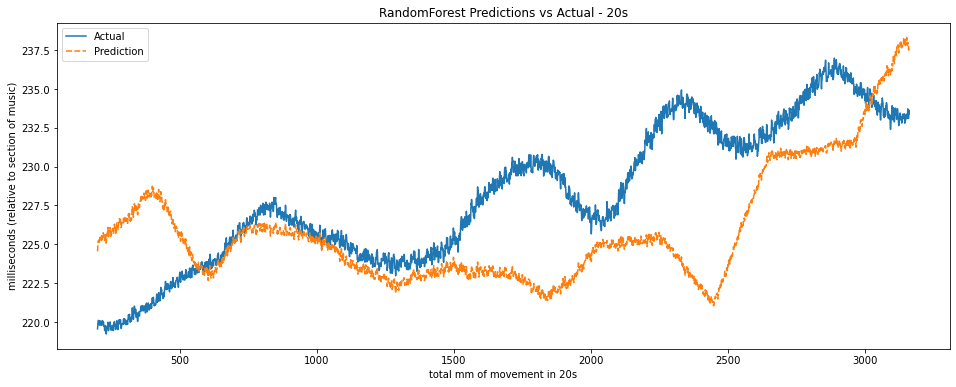

In [39]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(200).mean())
plt.title('RandomForest Predictions vs Actual - 20s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 20s')
plt.plot()

In [38]:
pd.DataFrame(rf.feature_importances_.reshape(1,-1), 
             columns=cols).T.rename(columns={0:'Importances'}).sort_values(by='Importances', 
                                                                           ascending=False).head(15)

,Importances
Z_20s_max,0.730225
Height,0.070922
total_eucl,0.041535
X_20s_max,0.031536
Z_disp_start,0.017053
X_scale_mean,0.013865
X_disp_total,0.012068
X_20s_min,0.010910
Age,0.008319
Y_disp_total,0.007770


From here we should move forward with RandomForest using Randomized Search to find better hyperparameters.